In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
# 1. 데이터 로드

# 파일에 헤더(컬럼명)가 없다면 header=None로 읽고 컬럼명 지정
file_path = "/content/drive/MyDrive/Colab Notebooks/기계학습프로그래밍/11주/WISDM.csv"
df = pd.read_csv(file_path, header=None, names=['index', 'user', 'activity', 'timestamp', 'x', 'y', 'z'])

print("원본 데이터 샘플:")
print(df.head())
print("\n활동 종류 빈도:")
print(df['activity'].value_counts())

원본 데이터 샘플:
   index  user activity     timestamp         x          y         z
0      0    33  Jogging  4.910600e+13 -0.694638  12.680544  0.503953
1      1    33  Jogging  4.910610e+13  5.012288  11.264028  0.953424
2      2    33  Jogging  4.910610e+13  4.903325  10.882658 -0.081722
3      3    33  Jogging  4.910620e+13 -0.612916  18.496431  3.023717
4      4    33  Jogging  4.910630e+13 -1.184970  12.108489  7.205164

활동 종류 빈도:
activity
Walking       406775
Jogging       325975
Upstairs      118589
Downstairs     97813
Sitting        54876
Standing       44547
Name: count, dtype: int64


In [3]:
# 2. 관심 활동 필터링 (Walking vs Sitting)

normal_activity = 'Walking'
anomaly_activity = 'Sitting'  # 너가 명시한 이상치

# 필터: Walking과 Sitting만 대상으로 실험
df = df[df['activity'].isin([normal_activity, anomaly_activity])].copy()
df.reset_index(drop=True, inplace=True)

print(f"\n필터 후 데이터 shape: {df.shape}")
print(df['activity'].value_counts())


필터 후 데이터 shape: (461651, 7)
activity
Walking    406775
Sitting     54876
Name: count, dtype: int64


In [4]:
# 3. 불필요 컬럼 제거 및 결측치 처리

# index, user, timestamp는 제거
df = df.drop(columns=['index', 'user', 'timestamp'], errors='ignore')
df = df.dropna().reset_index(drop=True)

# 라벨 생성: 0 = Normal(Walking), 1 = Anomaly(Sitting)
df['Class'] = df['activity'].apply(lambda x: 0 if x == normal_activity else 1)
df = df.drop(columns=['activity'])

print("\n정리된 데이터 샘플:")
print(df.head())
print("\nClass 분포:\n", df['Class'].value_counts())


정리된 데이터 샘플:
          x          y         z  Class
0  0.844462   8.008764  2.792171      0
1  1.116869   8.621680  3.786457      0
2 -0.503953  16.657684  1.307553      0
3  4.794363  10.760075 -1.184970      0
4 -0.040861   9.234595 -0.694638      0

Class 분포:
 Class
0    406775
1     54876
Name: count, dtype: int64


In [5]:
# 4. 피처 스케일링 (x,y,z)

features = ['x', 'y', 'z']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [17]:
# 5. train/test 분리 (이상치 비율 조정 포함)

X_train_df, X_test_df = train_test_split(
    df, test_size=0.2, random_state=RANDOM_SEED, stratify=df['Class']
)

# 학습은 정상(Class == 0, Walking)만 사용
X_train_df = X_train_df[X_train_df['Class'] == 0].copy()

# -----------------------------
# 테스트셋의 이상치 비율 조정
# -----------------------------
normal_test = X_test_df[X_test_df['Class'] == 0]
anomaly_test = X_test_df[X_test_df['Class'] == 1]

# 원하는 이상치 비율 설정 (예: 0.03 = 3%)
desired_ratio = 0.03
n_anomaly = int(len(normal_test) * desired_ratio)

# 이상치 수가 너무 적으면 최소 1개라도 유지
if n_anomaly < 1:
    n_anomaly = 1

# 이상치 샘플 줄이기
anomaly_test = anomaly_test.sample(n=n_anomaly, random_state=RANDOM_SEED)

# 다시 합쳐서 섞기
X_test_df = pd.concat([normal_test, anomaly_test]).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# 피처 / 라벨 분리
y_test = X_test_df['Class'].values
X_train = X_train_df[features].values
X_test = X_test_df[features].values

print(f"\nX_train shape (정상만): {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"테스트 내 클래스 분포: {np.bincount(y_test)}  # [normal_count, anomaly_count]")
print(f"이상치 비율: {100 * np.mean(y_test):.2f}%")



X_train shape (정상만): (325419, 3)
X_test shape: (83796, 3)
테스트 내 클래스 분포: [81356  2440]  # [normal_count, anomaly_count]
이상치 비율: 2.91%


In [18]:
# 6. AutoEncoder 모델 정의 (간단한 Fully-connected)

input_dim = X_train.shape[1]   # 3 (x,y,z)
encoding_dim = 2               # latent 크기 (조정 가능)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# 7. 모델 학습

history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0849 - val_loss: 0.5460
Epoch 2/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4834 - val_loss: 0.3220
Epoch 3/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2828 - val_loss: 0.2365
Epoch 4/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2287 - val_loss: 0.2242
Epoch 5/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2197 - val_loss: 0.2202
Epoch 6/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2165 - val_loss: 0.2184
Epoch 7/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2150 - val_loss: 0.2175
Epoch 8/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2142 - val_loss: 0.2170
Epoch 9/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2138 - val_loss: 0.2167
Epoch 10/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2136 - val_loss: 0.2165
Epoch 11/50
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2135 - val_loss: 0.2164
Epoch 12/50
1145/1145 ━━━━━━━━

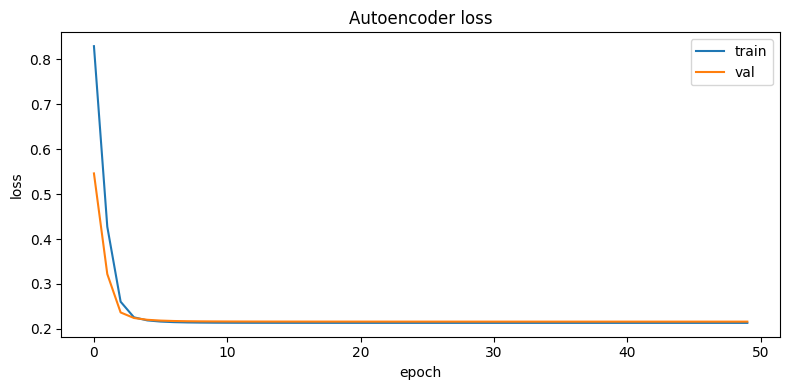

In [20]:
# loss 곡선 시각화

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Autoencoder loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# 8. 재구성 오차 계산 (train, test)

# train 재구성 오차 (임계값 결정용)
train_pred = autoencoder.predict(X_train)
mse_train = np.mean(np.power(X_train - train_pred, 2), axis=1)

# test 재구성 오차 (평가용)
test_pred = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - test_pred, 2), axis=1)

# DataFrame으로 정리
error_df = pd.DataFrame({'reconstruction_error': mse_test, 'true_class': y_test})
print("\n테스트 재구성 오차 요약:")
print(error_df['reconstruction_error'].describe())

10170/10170 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 2s 934us/step

테스트 재구성 오차 요약:
count    8.379600e+04
mean     2.451327e-01
std      4.747688e-01
min      6.413093e-07
25%      1.581356e-02
50%      7.575251e-02
75%      2.585743e-01
max      1.351768e+01
Name: reconstruction_error, dtype: float64



설정된 Threshold (train 95perc): 0.897742


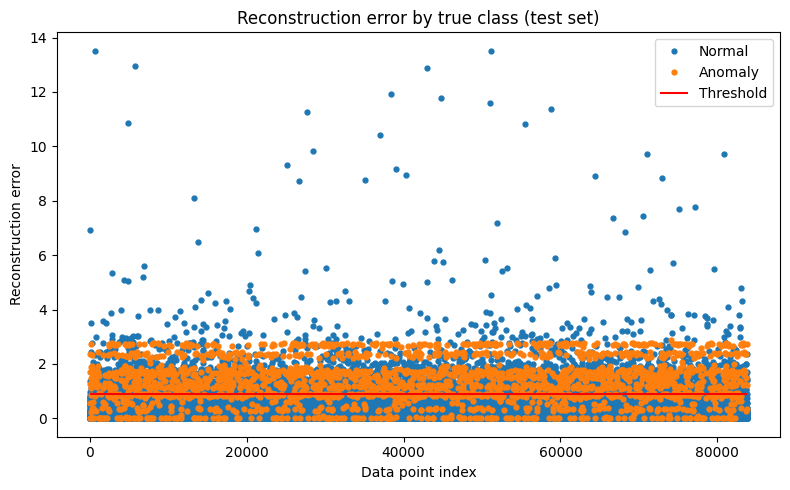

In [24]:
# 9. Threshold 설정
#    - 학습(정상) 재구성 오차의 95th percentile 사용

threshold = np.percentile(mse_train, 95)
print(f"\n설정된 Threshold (train 95perc): {threshold:.6f}")

# 시각화: 클래스별 재구성 오차 분포
plt.figure(figsize=(8,5))
groups = error_df.groupby('true_class')
for name, group in groups:
    plt.plot(group.index, group.reconstruction_error, marker='o', linestyle='', ms=3.5,
             label=('Anomaly' if name==1 else 'Normal'))
plt.hlines(threshold, xmin=0, xmax=len(error_df)-1, colors='r', label='Threshold')
plt.legend()
plt.title('Reconstruction error by true class (test set)')
plt.xlabel('Data point index')
plt.ylabel('Reconstruction error')
plt.tight_layout()
plt.show()

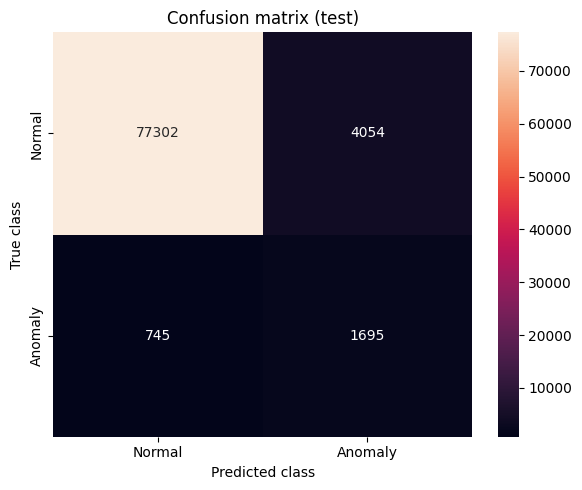


Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97     81356
     Anomaly       0.29      0.69      0.41      2440

    accuracy                           0.94     83796
   macro avg       0.64      0.82      0.69     83796
weighted avg       0.97      0.94      0.95     83796



In [23]:
# 10. 평가: confusion matrix 및 classification report

y_pred = (mse_test > threshold).astype(int)

LABELS = ["Normal", "Anomaly"]
conf_matrix = confusion_matrix(error_df['true_class'], y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion matrix (test)')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(error_df['true_class'], y_pred, target_names=LABELS))